In [33]:
# Dependencies
import numpy as np
import pandas as pd
import datetime as dt
import math
import psycopg2
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

import pandas_ta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split


In [18]:
# load password
from config import db_password

# Assign connection values
url = "finalproject.crrfdeawjuaz.us-east-1.rds.amazonaws.com"
port = "5432"
db_name = "tesla"

In [19]:
# Connect to the AWS database
from sqlalchemy import create_engine
db_string = f"postgresql://postgres:{db_password}@{url}:{port}/{db_name}"
engine = create_engine(db_string)
conn = engine.connect()

Exception during reset or similar
Traceback (most recent call last):
  File "C:\Anaconda\envs\mlenv\lib\site-packages\sqlalchemy\pool\base.py", line 670, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Anaconda\envs\mlenv\lib\site-packages\sqlalchemy\pool\base.py", line 875, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Anaconda\envs\mlenv\lib\site-packages\sqlalchemy\engine\default.py", line 642, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



In [20]:
# read table daily values
df1 = pd.read_sql('SELECT * FROM "daily_values"', conn)
print(df1.shape)
df1.head()

(2821, 8)


,ticker,hdate,hopen,hhigh,hlow,hclose,hadjclose,hvolume
0,TSLA,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,TSLA,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,TSLA,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,TSLA,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,TSLA,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [21]:
# Reindex data using a DatetimeIndex
df2 = df1
df_series = pd.to_datetime(df2['hdate'])
df_index = pd.DatetimeIndex(df_series.values)
df3 = df2.set_index(df_index)
df3.drop('hdate', axis=1, inplace=True)
print(df3)

           ticker    hopen    hhigh     hlow   hclose  hadjclose   hvolume
2010-06-29   TSLA    3.800    5.000    3.508    4.778      4.778  93831500
2010-06-30   TSLA    5.158    6.084    4.660    4.766      4.766  85935500
2010-07-01   TSLA    5.000    5.184    4.054    4.392      4.392  41094000
2010-07-02   TSLA    4.600    4.620    3.742    3.840      3.840  25699000
2010-07-06   TSLA    4.000    4.000    3.166    3.222      3.222  34334500
...           ...      ...      ...      ...      ...        ...       ...
2021-09-03   TSLA  732.250  734.000  724.200  733.570    733.570  15246100
2021-09-07   TSLA  740.000  760.200  739.260  752.920    752.920  20039800
2021-09-08   TSLA  761.580  764.450  740.770  753.870    753.870  18793000
2021-09-09   TSLA  753.410  762.100  751.630  754.860    754.860  14077700
2021-09-10   TSLA  759.600  762.610  734.520  736.270    736.270  15114300

[2821 rows x 7 columns]


In [22]:
df4 = df3[['hclose']]
print(df4.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2821 entries, 2010-06-29 to 2021-09-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hclose  2821 non-null   float64
dtypes: float64(1)
memory usage: 44.1 KB
None


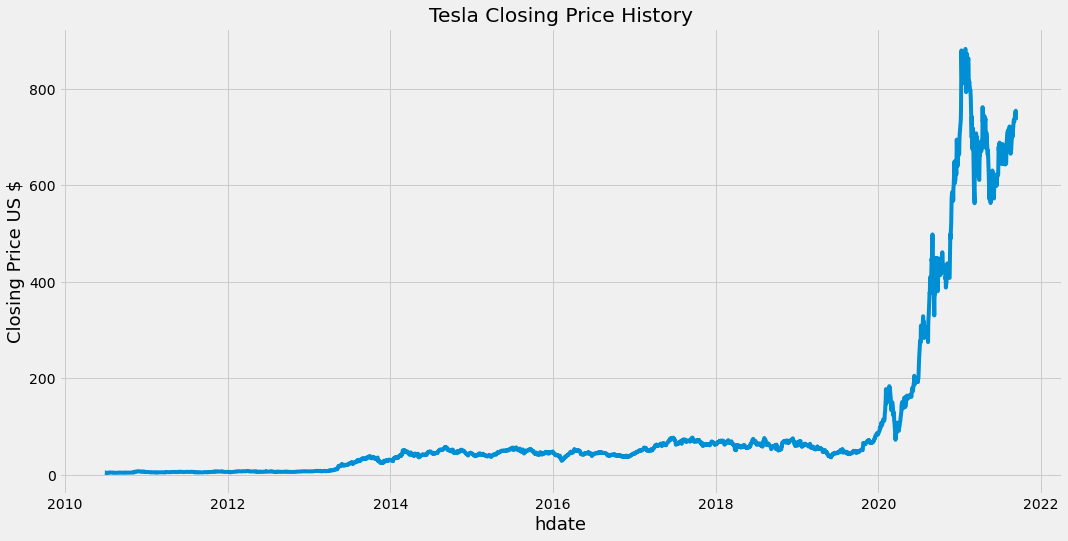

In [23]:
#Visualize closing price history
plt.figure(figsize=(16,8))
plt.title('Tesla Closing Price History')
plt.plot(df4['hclose'])
plt.xlabel('hdate', fontsize=18)
plt.ylabel('Closing Price US $', fontsize=18)
plt.show()

In [24]:
#Add technical indicators
df4.ta.ema(close='hclose', length=365, append=True)
print(df4.shape)
print(df4)

(2821, 2)
             hclose     EMA_365
2010-06-29    4.778         NaN
2010-06-30    4.766         NaN
2010-07-01    4.392         NaN
2010-07-02    3.840         NaN
2010-07-06    3.222         NaN
...             ...         ...
2021-09-03  733.570  527.302151
2021-09-07  752.920  528.535036
2021-09-08  753.870  529.766374
2021-09-09  754.860  530.996394
2021-09-10  736.270  532.118108

[2821 rows x 2 columns]


C:\Anaconda\envs\mlenv\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result


In [26]:
# Drop the nans
df4.dropna(subset=["EMA_365"], inplace=True)
print(df4.shape)
print(df4)

(2457, 2)
             hclose     EMA_365
2011-12-06    6.974    5.093068
2011-12-07    6.838    5.102604
2011-12-08    6.178    5.108480
2011-12-09    6.208    5.114488
2011-12-12    6.082    5.119775
...             ...         ...
2021-09-03  733.570  527.302151
2021-09-07  752.920  528.535036
2021-09-08  753.870  529.766374
2021-09-09  754.860  530.996394
2021-09-10  736.270  532.118108

[2457 rows x 2 columns]


C:\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


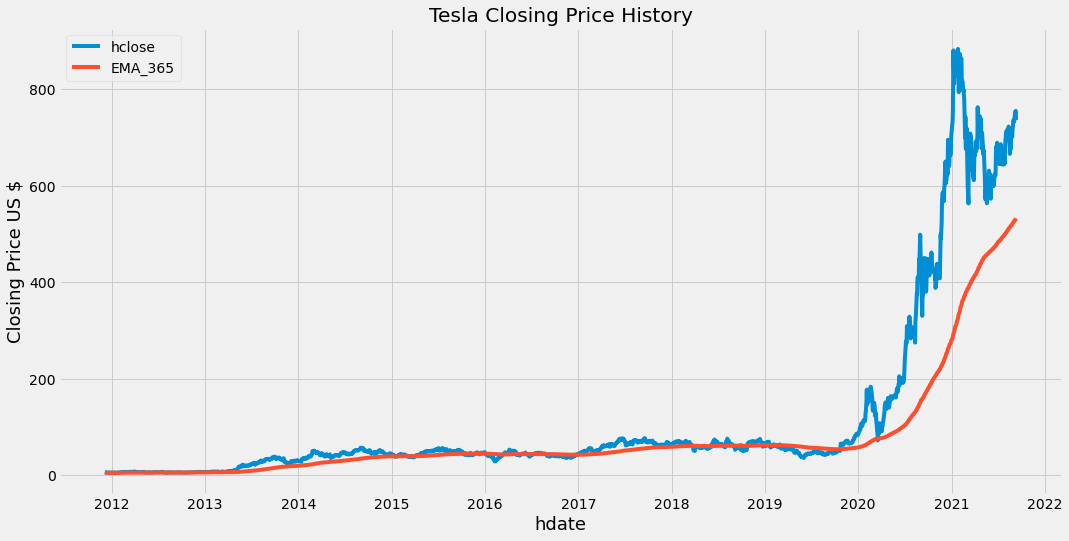

In [31]:
#Visualize closing price history
plt.figure(figsize=(16,8))
plt.title('Tesla Closing Price History')

plt.plot(df4[['hclose','EMA_365']])
plt.xlabel('hdate', fontsize=18)
plt.ylabel('Closing Price US $', fontsize=18)

plt.legend(['hclose', 'EMA_365'], loc='upper left')

plt.show()

In [34]:
# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(df4[['hclose']], df4[['EMA_365']], test_size=.2)

# Test set
print(X_test.describe())

           hclose
count  492.000000
mean   112.858602
std    185.251633
min      5.320000
25%     38.064500
50%     49.234000
75%     66.270000
max    872.790000


In [35]:
# Training set
print(X_train.describe())

            hclose
count  1965.000000
mean    114.612451
std     188.702945
min       4.558000
25%      38.600000
50%      48.980000
75%      68.206000
max     883.090000


In [36]:
from sklearn.linear_model import LinearRegression
# Create Regression Model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)

LinearRegression()

In [37]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Model Coefficients: [[0.54558092]]


NameError: name 'y_pred' is not defined